<a href="https://colab.research.google.com/github/jungfsg/AIFFEL_quest_cr/blob/main/Python/tmp/New_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import kagglehub
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import wandb
from wandb.integration.keras import WandbCallback
from datetime import datetime
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import warnings
from PIL import Image
import random
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [2]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# # 케글 기본 데이터셋

# path = kagglehub.dataset_download('anshtanwar/jellyfish-types')
# print("데이터셋 파일 경로:", path)
# print(os.listdir(path))

In [4]:
# 사전에 다운로드한 증강 데이터셋
# 구글드라이브 최상위 홈 디렉토리에 'DLTHON' 폴더 생성하고 Train_Valid_Test 폴더 업로드 하시면 됩니다
augpath = '/content/drive/MyDrive/DLTHON/Train_Valid_Test'
print("데이터셋 파일 경로:", augpath)
print(os.listdir(augpath))

데이터셋 파일 경로: /content/drive/MyDrive/DLTHON/Train_Valid_Test
['valid', 'Train', 'test']


In [5]:
# 테스트 데이터셋은 파일 차이 없음
aug_train_path = os.path.join(augpath, 'Train')
aug_valid_path = os.path.join(augpath, 'valid')
aug_test_path = os.path.join(augpath, 'test')

print(aug_train_path)
print(aug_valid_path)
print(aug_test_path)

# 파일 확인

print("\n훈련 파일:")
try:
    train_files = pd.DataFrame(os.listdir(aug_train_path), columns=['Files_Name'])
    print(train_files.head())
except FileNotFoundError:
    print(f"'Train' 폴더를 찾을 수 없습니다.")

print("\n검증 파일:")
try:
    valid_files = pd.DataFrame(os.listdir(aug_valid_path), columns=['Files_Name'])
    print(valid_files.head())
except FileNotFoundError:
    print(f"'valid' 폴더를 찾을 수 없습니다.")

/content/drive/MyDrive/DLTHON/Train_Valid_Test/Train
/content/drive/MyDrive/DLTHON/Train_Valid_Test/valid
/content/drive/MyDrive/DLTHON/Train_Valid_Test/test

훈련 파일:
                Files_Name
0     lions_mane_jellyfish
1         barrel_jellyfish
2           blue_jellyfish
3        compass_jellyfish
4  mauve_stinger_jellyfish

검증 파일:
                Files_Name
0        compass_jellyfish
1           blue_jellyfish
2  mauve_stinger_jellyfish
3         barrel_jellyfish
4     lions_mane_jellyfish


In [6]:
# 폴더 이미지 카운트
img_counts = []

# Train 폴더 내 모든 서브폴더 확인
for folder in os.listdir(aug_train_path):
    folder_path = os.path.join(aug_train_path, folder) # 서브폴더 경로

    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        img_counts.append({"Folder": folder,
                              "Image_Count": num_images})
# 데이터프레임으로 변환
df_counts = pd.DataFrame(img_counts)
print(df_counts)

                    Folder  Image_Count
0     lions_mane_jellyfish           77
1         barrel_jellyfish           77
2           blue_jellyfish           72
3        compass_jellyfish           77
4  mauve_stinger_jellyfish           77
5           Moon_jellyfish           77


In [7]:
def create_dataframe(image_folder):
    files = glob.glob(os.path.join(image_folder, '**', '*.*'), recursive=True)
    np.random.shuffle(files)
    labels = [os.path.basename(os.path.dirname(f)) for f in files]
    return pd.DataFrame({'Image': files, 'Label': labels})

dataframe_aug_train = create_dataframe(aug_train_path)
dataframe_aug_valid = create_dataframe(aug_valid_path)

Dataset                   Training  Validation
Label                                         
Moon_jellyfish           16.849015   16.949153
barrel_jellyfish         16.849015   16.949153
blue_jellyfish           15.754923   15.254237
compass_jellyfish        16.849015   16.949153
lions_mane_jellyfish     16.849015   16.949153
mauve_stinger_jellyfish  16.849015   16.949153


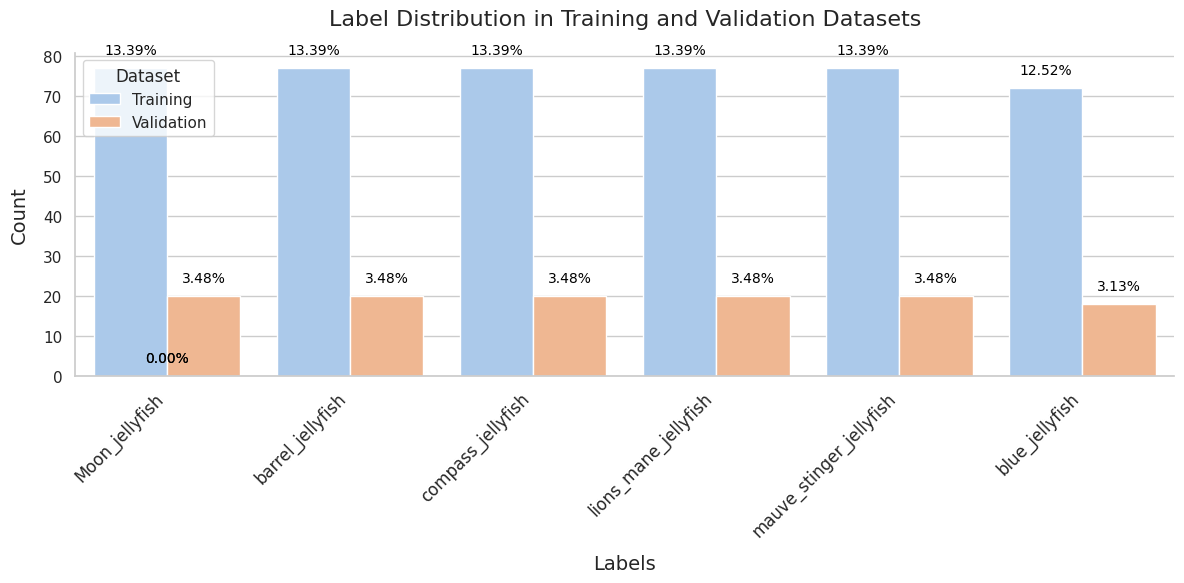

In [8]:
dataframe_aug_train['Dataset'] = 'Training'
dataframe_aug_valid['Dataset'] = 'Validation'

combined_df = pd.concat([dataframe_aug_train, dataframe_aug_valid], ignore_index=True)

sns.set_theme(style="whitegrid")

count_data = combined_df.groupby(['Label', 'Dataset']).size().unstack(fill_value=0)
percentage_data = count_data.div(count_data.sum(axis=0), axis=1) * 100

print(percentage_data)

palette = sns.color_palette("pastel", len(count_data))

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=combined_df, x="Label", hue="Dataset", order=count_data.sum(axis=1).sort_values(ascending=False).index, palette="pastel")

for p in ax.patches:
    height = p.get_height()
    percentage = f'{(height / len(combined_df)) * 100:.2f}%'
    ax.annotate(percentage,
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 8), textcoords='offset points')

plt.xticks(rotation=45, ha='right', fontsize=12)

plt.title("Label Distribution in Training and Validation Datasets", fontsize=16, pad=20)
plt.xlabel("Labels", fontsize=14, labelpad=10)
plt.ylabel("Count", fontsize=14, labelpad=10)

sns.despine()

plt.tight_layout()
plt.show()

In [9]:

# def grayscale_transform(img):
#     gray = tf.image.rgb_to_grayscale(img)
#     return tf.tile(gray, [1, 1, 3])  # 단일 채널을 3개로 복제하여 3채널 유지

def random_grayscale(img, p=0.5): # 확률만큼 이미지를 흑백처리
    if np.random.random() < p:
        gray = tf.image.rgb_to_grayscale(img)
        return tf.tile(gray, [1, 1, 3])
    else:
        return img

train_datagen = ImageDataGenerator(

    # 정규화
    rescale=1./255,

    # augmentation 부분
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.15,
    # zoom_range=0.15,
    # horizontal_flip=True,
    # fill_mode='nearest',
    # preprocessing_function=lambda img: random_grayscale(img, p=0.5)  # 흑백 변환 함수
)

valid_datagen = ImageDataGenerator(rescale=1./255)

target_size = (224, 224)
batch_size = 16

In [10]:
# 데이터 제너레이터 생성
train_generator = train_datagen.flow_from_directory(
    aug_train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    aug_valid_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

Found 457 images belonging to 6 classes.
Found 118 images belonging to 6 classes.


In [11]:
batch_size = 16
target_size = (224,224)
train= tf.keras.preprocessing.image_dataset_from_directory(
    aug_train_path,
    validation_split=None,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    aug_valid_path,
    validation_split=None,
    image_size=target_size,
    batch_size=batch_size,
)

Found 457 files belonging to 6 classes.
Found 118 files belonging to 6 classes.


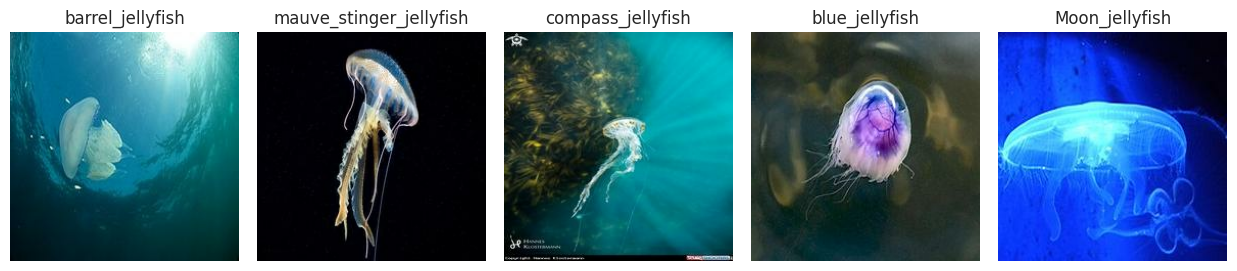

In [12]:
# class_labels = train.class_names
class_labels = list(train_generator.class_indices.keys()) # 수정

plt.figure(figsize=(15, 10))

shown_classes = set()

for images, labels in train.take(1):
    for i in range(len(images)):
        class_name = class_labels[labels[i]]
        if class_name not in shown_classes:
            ax = plt.subplot(1, 6, len(shown_classes) + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_name)
            plt.axis("off")
            shown_classes.add(class_name)

        if len(shown_classes) == len(class_labels):
            break

plt.tight_layout()
plt.show()

In [13]:
run_name = f"vgg16-{datetime.now().strftime('%Y%m%d-%H%M%S')}"
wandb.init(
    # 프로젝트 폴더명 설정
    project="jellyfish-aug-dataset",
    name=run_name,
    )

config = wandb.config
config.learning_rate = 0.001
config.batch_size = 16
config.epochs = 15
config.optimizer = "adam"
config.model = "VGG16"


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jungfsg (jungfsg-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [14]:
# 모델 정의
base_model = tf.keras.applications.VGG16(
    include_top=False,  # 완전 연결 레이어 제외
    weights='imagenet',
    input_shape=(224, 224, 3)  # 입력 이미지 크기
)

base_model.trainable = False

# 새로운 분류 헤드 추가
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(train.class_names), activation='softmax')  # 해파리 클래스 수에 맞게
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [15]:
# 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
# wandb 콜백 커스텀(VGG16 기반에서 기본 콜백함수는 오류가 자주 생긴다고 함)

class MyWandbCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None:
            wandb.log(logs, step=epoch)


In [17]:
# fit
# 수정
with tf.device('/GPU:0'):
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=15,
        callbacks=[MyWandbCallback()]
    )

Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 412s 14s/step - accuracy: 0.2211 - loss: 1.8811 - val_accuracy: 0.3814 - val_loss: 1.5062
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.4317 - loss: 1.4422 - val_accuracy: 0.5678 - val_loss: 1.2934
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.5576 - loss: 1.2297 - val_accuracy: 0.6356 - val_loss: 1.1506
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.6873 - loss: 0.9965 - val_accuracy: 0.6610 - val_loss: 1.0486
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7411 - loss: 0.8975 - val_accuracy: 0.6102 - val_loss: 1.0202
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.7467 - loss: 0.8175 - val_accuracy: 0.6610 - val_loss: 0.9368
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.7216 - loss: 0.8139 - val_accuracy: 0.7627 - val_loss: 0.8323
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.8251 - loss: 0.6745 - val_accuracy: 0.

In [18]:
pd.DataFrame(os.listdir(aug_test_path),columns=['Files_Name'])

,Files_Name
0,compass_jellyfish
1,lions_mane_jellyfish
2,blue_jellyfish
3,mauve_stinger_jellyfish
4,barrel_jellyfish
5,Moon_jellyfish


In [19]:
# 테스트 데이터셋은 파일 차이 없음
test = tf.keras.preprocessing.image_dataset_from_directory(
    aug_test_path,
    image_size=(224,224),
    validation_split=None,
)

Found 40 files belonging to 6 classes.


In [20]:
validation_rescaled = validation.map(lambda x, y: (x / 255.0, y))

valid_score, valid_acc = model.evaluate(validation_rescaled)
print('Val Loss =', valid_score)
print('Val Accuracy =', valid_acc)

test_score, test_acc = model.evaluate(test)
print('Test Loss =', test_score)
print('Test Accuracy =', test_acc)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.7718 - loss: 0.6342
Val Loss = 0.6162271499633789
Val Accuracy = 0.7966101765632629
2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.7771 - loss: 10.5782
Test Loss = 10.813760757446289
Test Accuracy = 0.7749999761581421
